# Detection and Classification of ADHD using fMRI Scans

![MRI](https://media.istockphoto.com/photos/magnetic-resonance-imaging-mri-photosensitive-epilepsy-seizures-picture-id1292254104?s=612x612)

## Introduction

#### ADHD is one of the most underdiagnosed illnesses due to the lack of objective testing since it heavily relies on subjective testing and reporting.
#### The change in how mental illnesses are being diagnosed is still a new field that is under constant development and updates.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import os
import sys
from datetime import datetime

import tensorflow as tf

from tensorflow.keras.layers import Conv3D, MaxPool3D, TimeDistributed, Flatten, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import CSVLogger
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import nibabel as nib
import logging
import glob
import shutil
from keras import regularizers


import random
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import surface

### Dataset sorting

In [283]:
model_data = pd.read_csv("C:\\Users\\hagar\\OneDrive\\Desktop\\new GP - Copy\\Diagnosing-ADHD-With-ConvLSTM-master\\References\\img.csv")
# print(model_data)

# splitting data by class #
dx = dict(tuple(model_data.groupby(['DX'])))
dx0 = dx[0]
dx1 = dx[1]
dx2 = dx[2]
dx3 = dx[3]

# dx0.Image.to_csv('C:\\Users\\hagar\\OneDrive\\Desktop\\data\\dx0.csv', index=False)
# dx1.Image.to_csv('C:\\Users\\hagar\\OneDrive\\Desktop\\data\\dx1.csv', index=False)
# dx2.Image.to_csv('C:\\Users\\hagar\\OneDrive\\Desktop\\data\\dx2.csv', index=False)
# dx3.Image.to_csv('C:\\Users\\hagar\\OneDrive\\Desktop\\data\\dx3.csv', index=False)

# print(dx1)

partition = {'train': model_data['Image'].values}
train_labels = {}
for index, row in model_data.iterrows():
    train_labels[row['Image']] = row['DX']

val_labels = {}
for index, row in model_data.iterrows():
    val_labels[row['Image']] = row['DX']


data_folder = ("C:\\Users\hagar\OneDrive\Documents\gp\dataset")    

pattern = glob.glob("C:\\Users\\hagar\\OneDrive\\Documents\\gp\\dataset\\*\\rest_1\\NIfTI\\*")

newlist = []
for word in pattern:
    word = word.split(",")
    newlist.extend(word)
# print(newlist[0])

# change name of nii file to move it to a new directory #

# for i in range(len(newlist)):
#     filenum = 0
#     for f in newlist:
#         os.rename(f,f.replace("rest.nii",str(filenum)+"rest.nii"))
#         filenum += 1


# move files according to their class #

for i in range(len(newlist)):
    temp = []
    temp.append(newlist[i].split(os.sep))
    # print(temp[0][7])
    if (temp[0][7] == (dx0.Image)).any():
        dst = 'C:\\Users\\hagar\\OneDrive\\Documents\\gp\\0'
        print(newlist[i])
        # shutil.move(newlist[i],dst)


## Visualization for Dataset

### Spatial maps for raw fMRIs

Image shape is (96, 96, 47, 152)
Detected 152 spatial maps
--------------------------------------------------


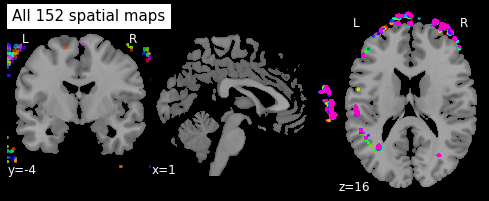

In [268]:
smri = "C:\\Users\\hagar\\OneDrive\\Desktop\\ch2better.nii"
subject_img = nl.image.load_img("C:\\Users\\hagar\\OneDrive\\Documents\\gp\\0\\25rest.nii.gz")

print("Image shape is %s" % (str(subject_img.shape)))
num_components = subject_img.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))
nlplt.plot_prob_atlas(subject_img,bg_img=smri, view_type='filled_contours',
                          draw_cross=False, title='All %d spatial maps' % num_components, threshold='auto')
print("-"*50)

### Spatial maps for pre-processed fMRIs

Image shape is (49, 58, 47, 120)
Detected 120 spatial maps
--------------------------------------------------


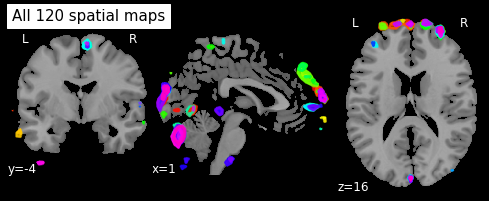

In [12]:
smri = r"C:\Users\hagar\OneDrive\Desktop\Final GP models\ch2better.nii"
subject_img = nl.image.load_img(r"D:\kki\1577042\sfnwmrda1577042_session_1_rest_1.nii.gz")

print("Image shape is %s" % (str(subject_img.shape)))
num_components = subject_img.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))
nlplt.plot_prob_atlas(subject_img,bg_img=smri, view_type='filled_contours',
                          draw_cross=False, title='All %d spatial maps' % num_components, threshold='auto')
print("-"*50)

Image shape is (49, 58, 47, 120)
Detected 120 spatial maps
(49, 58, 47)
--------------------------------------------------


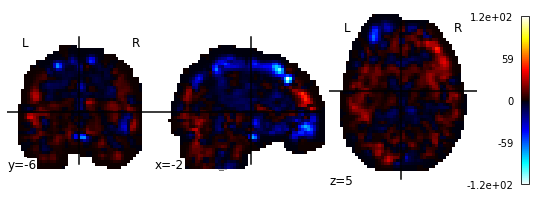

In [13]:
subject_img = nl.image.load_img(r"D:\kki\1577042\sfnwmrda1577042_session_1_rest_1.nii.gz")
print("Image shape is %s" % (str(subject_img.shape)))
num_components = subject_img.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))
rsn = subject_img
#convert to 3d image
first_rsn = image.index_img(rsn, 0)
print(first_rsn.shape)
plotting.plot_stat_map(first_rsn)
print("-"*50)

Image shape is (49, 58, 47, 120)
Detected 120 spatial maps
(49, 58, 47)
--------------------------------------------------


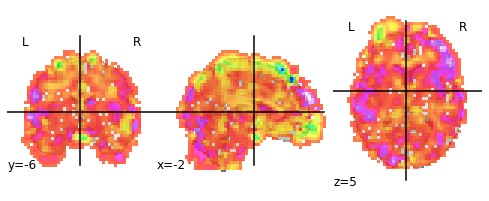

In [15]:
subject_img = nl.image.load_img(r"D:\kki\1577042\sfnwmrda1577042_session_1_rest_1.nii.gz")
print("Image shape is %s" % (str(subject_img.shape)))
num_components = subject_img.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))
rsn = subject_img
 #convert to 3d image
first_rsn = image.index_img(rsn, 0)
print(first_rsn.shape)
plotting.plot_roi(first_rsn)
print("-"*50)

(96, 96, 47)
--------------------------------------------------


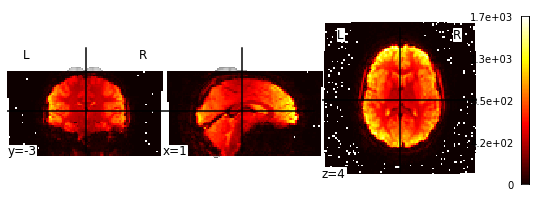

In [208]:
rsn = subject_img
    #convert to 3d image
first_rsn = image.index_img(rsn, 0)
print(first_rsn.shape)
plotting.plot_stat_map(first_rsn)
print("-"*50)

### Dataset attributes presentation

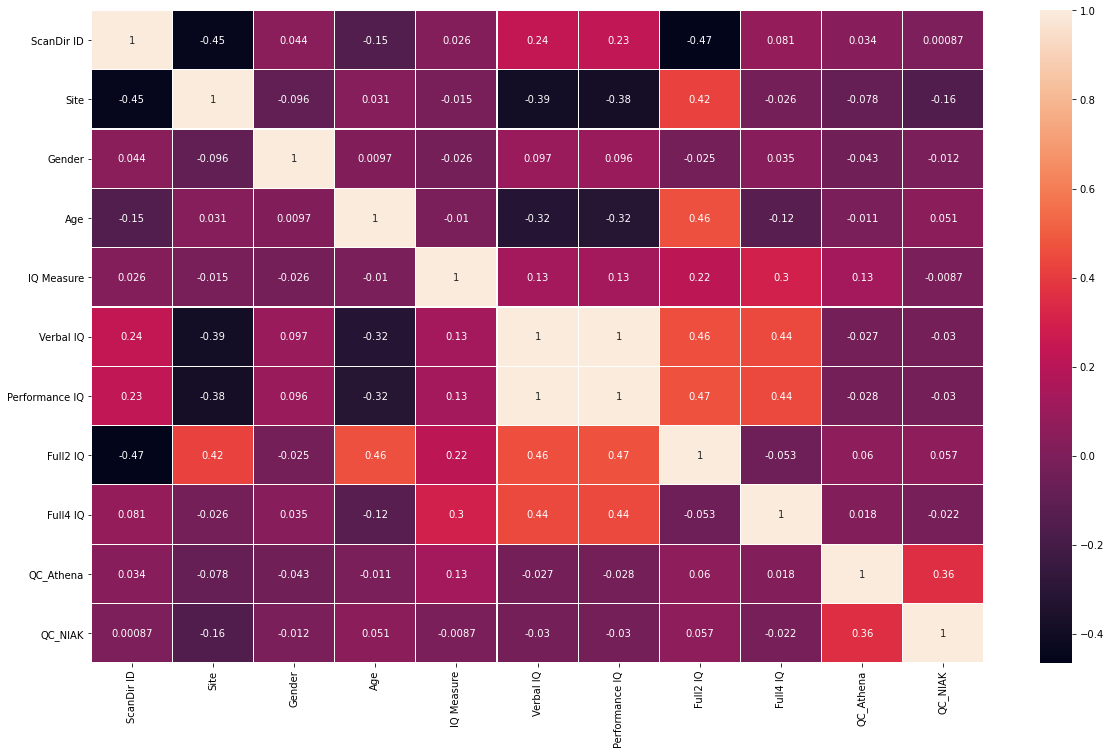

In [247]:
features = pd.read_table("C:\\Users\\hagar\\OneDrive\\Desktop\\new GP\\Diagnosing-ADHD-With-ConvLSTM-master\\References\\adhd200_preprocessed_phenotypics.tsv")

sns.heatmap(features.corr(),annot=True,linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [350]:
target_col = ['Age', 'Gender', 'Performance IQ']

Text(0.5, 1.0, 'Performance IQ')

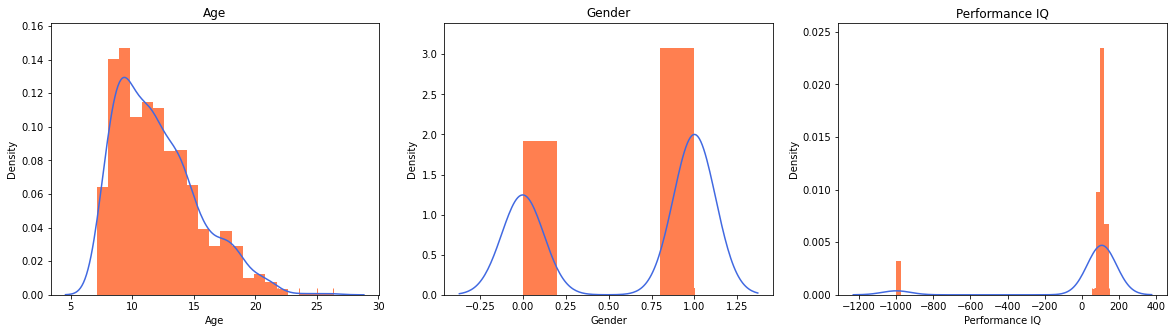

In [352]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.distplot(features['Age'], ax=ax[0],rug=True, rug_kws={"color": "coral"},
                  kde_kws={"color": "royalblue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 1, "color": "coral"}).set_title('Age')

sns.distplot(features['Gender'], ax=ax[1],rug=True, rug_kws={"color": "coral"},
                  kde_kws={"color": "royalblue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 1, "color": "coral"}).set_title('Gender')

sns.distplot(features['Performance IQ'], ax=ax[2],rug=True, rug_kws={"color": "coral"},
                  kde_kws={"color": "royalblue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 1, "color": "coral"}).set_title('Performance IQ')

<Figure size 1440x1080 with 0 Axes>

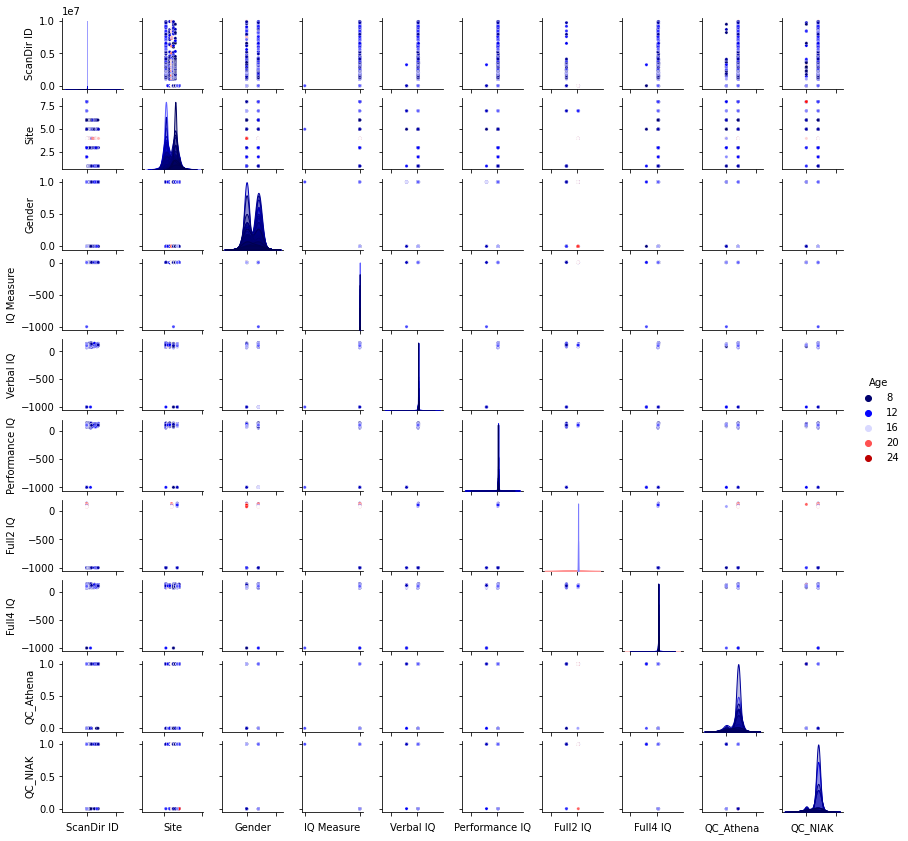

In [239]:
plt.figure(figsize=(20,15))
g = sns.pairplot(data=features, hue='Age', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Model Development

### fMRI Data Work

In [2]:
# ============================ DATA WORK ============================

file_num = 1

# Dataframes
dataset_dir = "D:\\kki"
model_train_data = pd.read_csv(r"C:\Users\hagar\OneDrive\Desktop\training_data")
model_val_data = pd.read_csv(r"C:\Users\hagar\OneDrive\Desktop\validation_data")


print(model_train_data)
# Dictionary of data values
partition = {'train': model_train_data['Image'].values, 
             'validation': model_val_data['Image'].values}



# Training Data
train_labels = {}
for index, row in model_train_data.iterrows():
    train_labels[row['Image']] = row['DX']

# print(train_labels)

    
# Validation Data
val_labels = {}
for index, row in model_val_data.iterrows():
    val_labels[row['Image']] = row['DX']
# print(val_labels)

                                                 Image  DX
0    D:\kki\2104012\snwmrda2104012_session_1_rest_1...   0
1    D:\kki\2138826\snwmrda2138826_session_1_rest_1...   0
2    D:\kki\2299519\snwmrda2299519_session_1_rest_1...   1
3    D:\kki\2344857\snwmrda2344857_session_1_rest_1...   0
4    D:\kki\2360428\snwmrda2360428_session_1_rest_1...   0
..                                                 ...  ..
475  D:\OHSU\2232376\sfnwmrda2232376_session_1_rest...   0
476  D:\OHSU\2232376\sfnwmrda2232376_session_1_rest...   0
477  D:\OHSU\2232376\snwmrda2232376_session_1_rest_...   0
478  D:\OHSU\2232376\snwmrda2232376_session_1_rest_...   0
479  D:\OHSU\2232376\snwmrda2232376_session_1_rest_...   0

[480 rows x 2 columns]


### fMRI data pre-processing

In [3]:
import numpy as np
import tensorflow.keras as keras
from scipy.ndimage import zoom
import os
import nibabel as nib

class FMRIDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataset_dir, batch_size):
        'Initialization'
        self.x_dim = 49
        self.y_dim = 58
        self.z_dim = 47
        self.time_length = 177
        self.img_dim = (self.x_dim, self.y_dim, self.z_dim) 
        self.dim = [self.time_length, 28, 28, 28, 1] # [time, x, y, z, c]
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = 1
        self.n_classes = 1
        self.shuffle = True
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)
                
        for i, img_path in enumerate(list_IDs_temp):
            X[i,] = self.preprocess_image(img_path)
            y[i] = self.labels[img_path]

        return X,y

    # Image Preprocessing Methods
    def preprocess_image(self, img_path):
        # print(img_path)
        img = nib.load(os.path.join(self.dataset_dir, img_path))

        pp_img = None
        if img.shape[3] > self.time_length:
            pp_img = self.truncate_image(img)
        elif img.shape[3] < self.time_length:
            pp_img = self.pad_image(img)
        else:
            pp_img = img.get_fdata()

        # For each image at the index-th time step, do this
        new_x=28/49
        new_y=28/58
        new_z=28/47
        
        new_img = []
        for index in range(self.time_length):
            z_img = zoom(pp_img[:,:,:,index], (new_x,new_y,new_z), order=1)
            new_img.append(z_img.reshape((28,28,28,1)))
        
        f_img = np.array(new_img)
        return f_img
    
    def truncate_image(self, img):
        return img.get_fdata()[:,:,:,:self.time_length]

    def pad_image(self, img):
        img_padding = np.expand_dims(np.zeros((self.x_dim,self.y_dim,self.z_dim)), axis=3)
        amt_to_fill = self.time_length - img.get_fdata().shape[3]
        padded_img = img.get_fdata()
        for _ in range(amt_to_fill):
            padded_img = np.append(arr=padded_img, values=img_padding, axis=3)

        return padded_img

### Model

In [4]:
# ============================ MODEL META ============================

epochs = 20
batch_size = 10
input_shape=(177,28,28,28,1)

train_steps_per_epoch = model_train_data.shape[0] // batch_size
validate_steps_per_epoch = model_val_data.shape[0] // batch_size

# Generators
training_generator = FMRIDataGenerator(partition['train'], train_labels, dataset_dir, batch_size)
validation_generator = FMRIDataGenerator(partition['validation'], val_labels, dataset_dir, batch_size)

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5)

logger_path = r"C:\Users\hagar\OneDrive\Desktop\model_data.csv"

csv_logger = CSVLogger(logger_path, append=True)

callbacks = [early_stopping,csv_logger]

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [5]:
# ============================ MODEL ARCHITECTURE ============================
with tf.device('/cpu:0'):
    
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(TimeDistributed(Conv3D(filters=64,kernel_size=(3,3,3),activation='sigmoid'),
                                  input_shape=input_shape, name="Input_Conv_Layer"))

    cnn_lstm_model.add(TimeDistributed(MaxPool3D(
                                    pool_size=(2, 2, 2),
                                    strides=(2, 2, 2),
                                    padding='valid'
                                    ), name="Pool_Layer_1"))

    cnn_lstm_model.add(TimeDistributed(Flatten(), name="Flatten_Layer"))

    cnn_lstm_model.add(TimeDistributed(BatchNormalization(), name="Batch_Normalize"))

    cnn_lstm_model.add(Dense(2, activation = 'sigmoid', name="Hidden_Layer" , kernel_regularizer=regularizers.l2(0.01)))
    
# with tf.device('/cpu:0'):

    cnn_lstm_model.add(Dropout(0.25, name="Dropout_Layer"))

    cnn_lstm_model.add(LSTM(10, dropout = 0.3, recurrent_dropout = 0.3, name="LSTM_Layer"))

#     cnn_lstm_model.add(Dense(20, activation = 'sigmoid', name="Hidden_Layer_3"))


with tf.device('/gpu:0'):

    cnn_lstm_model.add(Dense(1, activation = 'sigmoid', name="Output_Dense_Layer"))

    cnn_lstm_model.compile(optimizer=optimizers.SGD(lr=0.00001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    cnn_lstm_model.summary()

    # cnn_lstm_model.fit_generator(generator=training_generator,
    # steps_per_epoch=train_steps_per_epoch, verbose=1,
    # validation_data=validation_generator, validation_steps=validate_steps_per_epoch,
    # epochs=epochs, callbacks=[early_stopping,csv_logger])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Conv_Layer (TimeDistri (None, 177, 26, 26, 26, 6 1792      
_________________________________________________________________
Pool_Layer_1 (TimeDistribute (None, 177, 13, 13, 13, 6 0         
_________________________________________________________________
Flatten_Layer (TimeDistribut (None, 177, 140608)       0         
_________________________________________________________________
Batch_Normalize (TimeDistrib (None, 177, 140608)       562432    
_________________________________________________________________
Hidden_Layer (Dense)         (None, 177, 2)            281218    
_________________________________________________________________
Dropout_Layer (Dropout)      (None, 177, 2)            0         
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 10)                5

### Accuracy and Loss plots

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

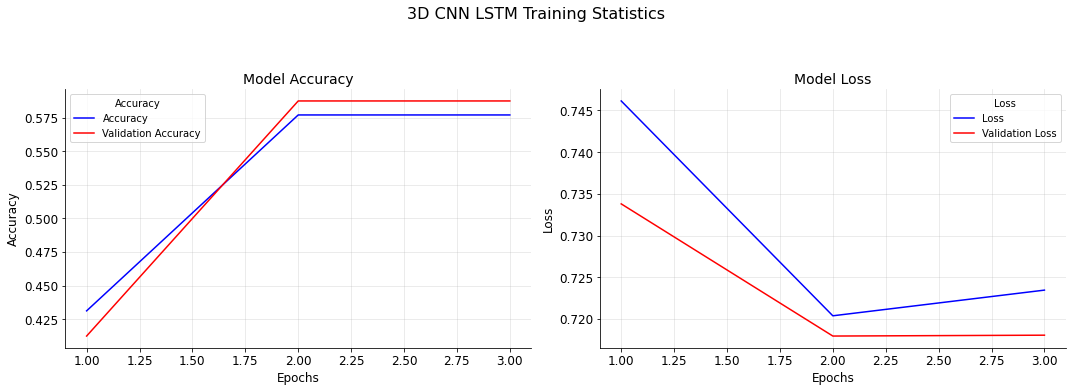

In [11]:
from pandas import DataFrame
df = pd.read_csv(logger_path)
training_process_viz(df, 
                     plot_title = '3D CNN LSTM Training Statistics')
